In [1]:
from jrieke import interpretation
from jrieke.utils import load_nifti

import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

from settings import settings
from nmm_mask_areas import short_name_map
for k in settings.keys():
    print("Adding " + k + " to namespace")
    globals()[k] = settings[k]

Adding model_path to namespace
Adding data_path to namespace
Adding ADNI_DIR to namespace
Adding 1.5T_table to namespace
Adding 1.5T_image_dir to namespace
Adding 3T_table to namespace
Adding 3T_image_dir to namespace
Adding binary_brain_mask to namespace
Adding nmm_mask_path to namespace


In [3]:
data_path = "/analysis/ritter/projects/Methods/LRP/data/rieke-copy1/2Node_trial0/beta0/"
mask_path = "/analysis/ritter/projects/Methods/LRP/data/"

#### Load results from evaluation notebook

In [4]:
cases = ["AD", "HC", "TP", "TN", "FP", "FN"]

mean_maps_LRP = dict()
mean_maps_GB = dict()
rs_per_area_LRP = dict()
rs_per_area_GB = dict()
for case in cases:
    mean_maps_LRP[case] = load_nifti(os.path.join(data_path, "LRP_{case}.nii".format(case=case)))
    mean_maps_GB[case] = load_nifti(os.path.join(data_path, "GB_{case}.nii".format(case=case)))
    with open(os.path.join(data_path, "LRP_area_evdcs_{case}.pkl".format(case=case)), 'rb') as file:
        rs_per_area_LRP[case] = pickle.load(file)
    with open(os.path.join(data_path, "GB_area_evdcs_{case}.pkl".format(case=case)), 'rb') as file:
        rs_per_area_GB[case] = pickle.load(file)
    
with open(os.path.join(data_path, 'area_sizes.pkl'), 'rb') as file:
    area_sizes = pickle.load(file)
    


##### Helper funtion to compute mean

In [5]:
def comp_mean(rs_per_area, case, area_norm=False):
    
    mean = dict()
    for area, result_list in rs_per_area[case].items():
        mean[area] = np.mean([area_sum for pat_idx, area_sum in result_list])
        if area_norm:
            mean[area] /= area_sizes[area]
    
    return mean

##### Compute mean scores per area  and sort labels according to importance

In [6]:
# Mean for AD and HC in LRP case
mean_ad_LRP = comp_mean(rs_per_area=rs_per_area_LRP, case="AD")
mean_hc_LRP = comp_mean(rs_per_area=rs_per_area_LRP, case="HC")
# Mean for AD and HC in GB case
mean_ad_GB = comp_mean(rs_per_area=rs_per_area_GB, case="AD")
mean_hc_GB = comp_mean(rs_per_area=rs_per_area_GB, case="HC")
# Mean for TP -- LRP case
mean_tp_LRP = comp_mean(rs_per_area=rs_per_area_LRP, case="TP")
# Mean for TP -- GB case
mean_tp_GB = comp_mean(rs_per_area=rs_per_area_GB, case="TP")


sorted_lbls_LRP = {
    
    "absolute": np.array(sorted(
        [(k, v) for k, v in mean_ad_LRP.items()], key=lambda x: float(x[1])))[:, 0],
    
    
    "area_norm": np.array(sorted(
        [(k, v/area_sizes[k]) for k, v in mean_ad_LRP.items()], key=lambda x: float(x[1])))[:, 0],
    
    
    "gain_ad": np.array(sorted(
        [(k, v/mean_hc_LRP[k]) for k, v in mean_ad_LRP.items()], key=lambda x: float(x[1])))[:, 0],
    
    
    "gain_tp": np.array(sorted(
       [(k, v/mean_hc_LRP[k]) for k, v in mean_tp_LRP.items()], key=lambda x: float(x[1])))[:, 0]
}

sorted_lbls_GB = {
    
    "absolute": np.array(sorted(
        [(k, v) for k, v in mean_ad_GB.items()], key=lambda x: float(x[1])))[:, 0],
    
    
    "area_norm": np.array(sorted(
        [(k, v/area_sizes[k]) for k, v in mean_ad_GB.items()], key=lambda x: float(x[1])))[:, 0],
    
    
    "gain_ad": np.array(sorted(
        [(k, v/mean_hc_GB[k]) for k, v in mean_ad_GB.items()], key=lambda x: float(x[1])))[:, 0],
    
    
    "gain_tp": np.array(sorted(
       [(k, v/mean_hc_GB[k]) for k, v in mean_tp_GB.items()], key=lambda x: float(x[1])))[:, 0]
}



In [7]:
# save sortings for comparison
np.save(os.path.join(data_path, "sorted_lbls_LRP_gain_tp.npy"), sorted_lbls_LRP["gain_tp"])
np.save(os.path.join(data_path, "sorted_lbls_area_norm.npy"), sorted_lbls_LRP["area_norm"])
np.save(os.path.join(data_path, "sorted_lbls_absolute.npy"), sorted_lbls_LRP["absolute"])

### Plotting function

In [7]:
def plot_ad_hc(mean_ad, mean_hc, plt_opts, sorting="absolute", fig=None, ax=None,
              idv_plots=None, plot_idvs=False, sort_dict=None,
              rs_per_a=None, patA=23, patB=64, the_labels=None, shift=False):
    
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(12,6))

    if the_labels is None:
        the_labels = np.array(sort_dict[sorting], dtype=str)
    ad_vals = np.array([mean_ad[l] for l in the_labels], dtype=float)
    
    if mean_hc is not None:
        hc_vals = np.array([mean_hc[l] for l in the_labels], dtype=float)
    
    
    x_vals = np.arange(len(the_labels))
    if shift:
        # Necessary for violin plots
        x_vals = x_vals+1
    
    if mean_hc is not None:
        
        ax.scatter(np.array(x_vals), hc_vals, color=plt_opts["color_hc"],
                   label=plt_opts["hc_label"], **plt_opts["scatter_style"],
                   zorder=20)
    
    ax.scatter(np.array(x_vals), ad_vals, color=plt_opts["color_ad"], 
               label=plt_opts["ad_label"], **plt_opts["scatter_style"],
              zorder=20)
    
    
    if plot_idvs:
        pat_A_idx = np.where(np.array(rs_per_area_LRP["TP"]["CSF"])[:, 0] == patA)[0][0]
        pat_B_idx = np.where(np.array(rs_per_area_LRP["TP"]["CSF"])[:, 0] == patB)[0][0]
        ax.plot(x_vals, np.array([np.array(rs_per_a["TP"][l])[pat_A_idx, 1]/(area_sizes[l]) for l in the_labels], dtype=float), 
                **plt_opts["idvs_style"], linestyle='dotted', label="Patient A")
        ax.plot(x_vals, np.array([np.array(rs_per_a["TP"][l])[pat_B_idx, 1]/(area_sizes[l]) for l in the_labels], dtype=float), 
                **plt_opts["idvs_style"], linestyle='dashed', label="Patient B")
    
    
    ###################
    ##################
    # Formatting
    ax.set_xticks(x_vals)
    ax.tick_params(axis='x', which='major', pad=10, length=5)

    ax.set_xticklabels(["{0:>25s}".format(short_name_map[e]) for e in the_labels], rotation="vertical",
                      fontsize=12)
    
    if "title" in plt_opts:
        ax.set_title(plt_opts["title"], fontsize=16)
    
    ax.set_ylabel(plt_opts["y_label"], fontsize=16)
    
    if "ylim" in plt_opts:
        ax.set_ylim(plt_opts["ylim"])

    ax.ticklabel_format(style='sci',scilimits=(-3,3),axis='y')

    return fig, ax 
    

## Absolute scores 

### LRP

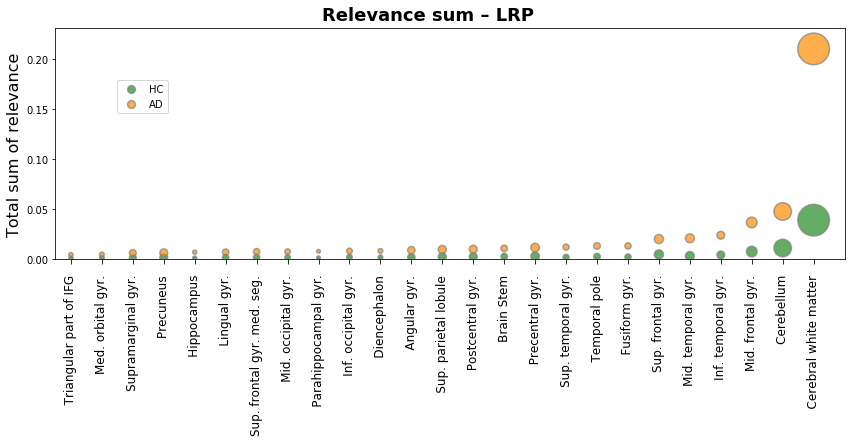

In [8]:
first_n = 25
the_labels = sorted_lbls_LRP["absolute"][-first_n:]
sizes = np.array([area_sizes[k] for k in the_labels])
sizes /= np.max(sizes)

plt_opts = {
    "scatter_style": {
        "edgecolors":'grey', 
        "lw":1.5, 
        "s": sizes*1000,
        "alpha": .7
    },
    "color_ad": "darkorange",
    "color_hc": "forestgreen",
    "y_label": "Total sum of relevance",
    "ad_label": "AD",
    "hc_label": "HC",
    }

fig, ax = plt.subplots(figsize=(12,6))
fig, ax = plot_ad_hc(mean_ad_LRP, mean_hc_LRP, plt_opts, sorting="absolute",
          the_labels=the_labels, fig=fig, ax=ax)

ax.set_xlim(-0.5, len(the_labels))
ax.set_ylim(0, 1.1 * np.max(mean_ad_LRP[the_labels[-1]]))
leg = fig.legend(bbox_to_anchor=[.2, .85])
for lh in leg.legendHandles: 
    lh._sizes= [60]
    
fig.suptitle("Relevance sum – LRP", y=1.017, fontweight="bold", fontsize=18)

fig.tight_layout()
# fig.savefig(os.path.join(data_path, "absolute_LRP.pdf"), bbox_inches='tight')

### GB

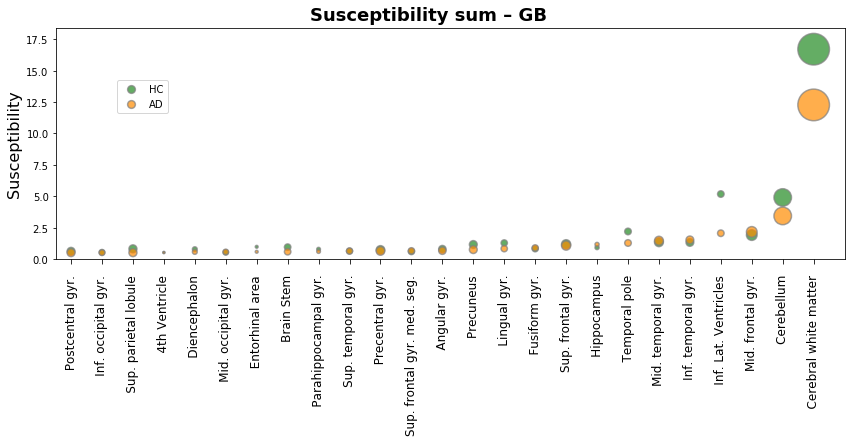

In [9]:
first_n = 25
the_labels = sorted_lbls_GB["absolute"][-first_n:]
sizes = np.array([area_sizes[k] for k in the_labels])
sizes /= np.max(sizes)

plt_opts = {
    "scatter_style": {
        "edgecolors":'grey', 
        "lw":1.5, 
        "s": sizes*1000,
        "alpha": .7
    },
    "color_ad": "darkorange",
    "color_hc": "forestgreen",
    "y_label": "Susceptibility",
    "ad_label": "AD",
    "hc_label": "HC",
    }

fig, ax = plt.subplots(figsize=(12,6))
fig, ax = plot_ad_hc(mean_ad_GB, mean_hc_GB, plt_opts, sorting="absolute",
          the_labels=the_labels, fig=fig, ax=ax)

ax.set_xlim(-0.5, len(the_labels))
ax.set_ylim(0, 1.5 * np.max(mean_ad_GB[the_labels[-1]]))
leg = fig.legend(bbox_to_anchor=[.2, .85])
for lh in leg.legendHandles: 
    lh._sizes= [60]
    
fig.suptitle("Susceptibility sum – GB", y=1.017, fontweight="bold", fontsize=18)

fig.tight_layout()
# fig.savefig(os.path.join(data_path, "absolute_GB.pdf"), bbox_inches='tight')

## Area normalized scores

##### Compute corresponding means


In [10]:
# How many patients per group – used for loop in cell below
num_ADs, num_HCs = len(rs_per_area_LRP["AD"]["CSF"]), len(rs_per_area_LRP["HC"]["CSF"])

# Means for ADs
mean_ad_LRP_norm = comp_mean(rs_per_area_LRP, "AD", area_norm=True)
mean_ad_GB_norm = comp_mean(rs_per_area_GB, "AD", area_norm=True)

# Means for HCs
mean_hc_LRP_norm = comp_mean(rs_per_area_LRP, "HC", area_norm=True)
mean_hc_GB_norm = comp_mean(rs_per_area_GB, "HC", area_norm=True)

# First 25 most important labels under this metric
labels_norm_LRP = np.array(sorted_lbls_LRP["area_norm"], dtype=str)[-first_n:]
labels_norm_GB = np.array(sorted_lbls_GB["area_norm"], dtype=str)[-first_n:]


###### Get individual patients' scores for violin plots

In [11]:
# Alzheimer's disease patients
evdc_vals_ad_LRP = np.array([[rs_per_area_LRP["AD"][l][patient][1]/(area_sizes[l]) 
                         for l in labels_norm_LRP] for patient in range(num_ADs)], dtype=float)
evdc_vals_ad_GB = np.array([[rs_per_area_GB["AD"][l][patient][1]/(area_sizes[l]) 
                         for l in labels_norm_GB] for patient in range(num_ADs)], dtype=float)

# Healthy controls
evdc_vals_hc_LRP = np.array([[rs_per_area_LRP["HC"][l][patient][1]/(area_sizes[l]) 
                         for l in labels_norm_LRP] for patient in range(num_HCs)], dtype=float)
evdc_vals_hc_GB = np.array([[rs_per_area_GB["HC"][l][patient][1]/(area_sizes[l]) 
                         for l in labels_norm_GB] for patient in range(num_HCs)], dtype=float)

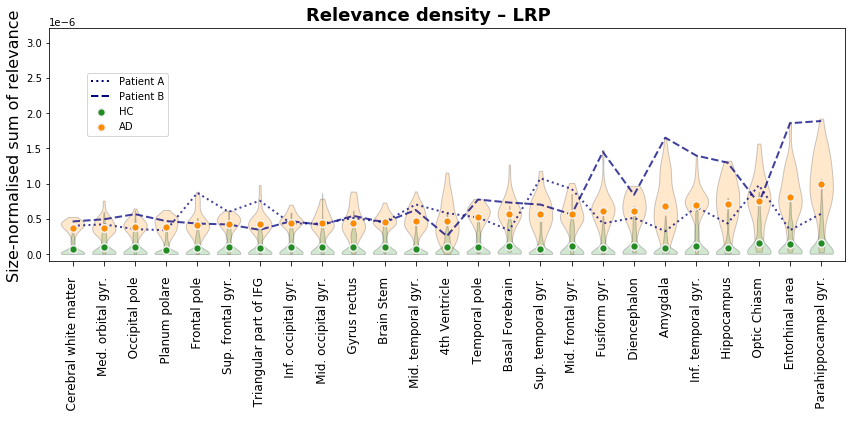

In [12]:
plt_opts = {
    
    "scatter_style": {
        "edgecolors": (.95, .95, .95), 
        "lw":1.5, 
        "s": 60, 
        "alpha":1},
        
    "idvs_style": {
        "alpha": .75, 
        "lw":2, 
        "color": "navy",
        "zorder": 10},
    
    "color_ad": "darkorange",
    "color_idvs": "navy",
    "color_hc": "forestgreen",
    "y_label": "Size-normalised sum of relevance",
    "ad_label": "AD",
    "hc_label": "HC",
    "ylim": (-1e-7, 3.2 * 1e-6)
    

}

fig, ax = plot_ad_hc(mean_ad_LRP_norm, mean_hc_LRP_norm, plt_opts, sorting="area_norm",
                     plot_idvs=True, rs_per_a=rs_per_area_LRP,
                     patB=2, 
                     shift=True,
                     patA=169,
                    the_labels=labels_norm_LRP)

parts = ax.violinplot(evdc_vals_ad_LRP, widths=.75, showextrema=False, points=100)
for pc in parts['bodies']:
    pc.set_facecolor(plt_opts["color_ad"])
    pc.set_edgecolor('black')
    pc.set_alpha(.2)

parts = ax.violinplot(evdc_vals_hc_LRP, widths=.75, showextrema=False, points=100)
for pc in parts['bodies']:
    pc.set_facecolor(plt_opts["color_hc"])
    pc.set_edgecolor('black')
    pc.set_alpha(.2)

ax.set_xlim(0.25, first_n+.75)
leg = fig.legend(bbox_to_anchor=[.2, .85])
for lh in leg.legendHandles: 
    lh.set_alpha(1)

fig.suptitle("Relevance density – LRP", y=1.0, fontweight="bold", fontsize=18)

fig.tight_layout()


# fig.savefig(os.path.join(data_path, "size_norm_LRP.pdf"))


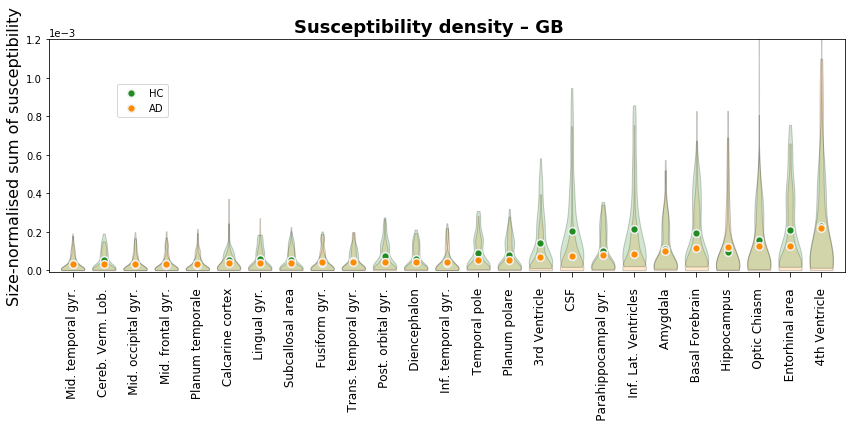

In [33]:
plt_opts = {
    
    "scatter_style": {
        "edgecolors": (.95, .95, .95), 
        "lw":1.5, 
        "s": 60, 
        "alpha":1},
        
    "hipps_style": {
        "alpha": .75, 
        "lw":2, 
        "color": "navy",
        "zorder": 10},
    
    "color_ad": "darkorange",
    "color_hipps": "navy",
    "color_hc": "forestgreen",
    "y_label": "Size-normalised sum of susceptibility",
    "ad_label": "AD",
    "hc_label": "HC",
    "ylim": (-1e-5, 1.2 * 1e-3)


}

fig, ax = plot_ad_hc(mean_ad_GB_norm, mean_hc_GB_norm, plt_opts, sorting="area_norm",
                     rs_per_a=rs_per_area_GB,
                     shift=True,
                    the_labels=labels_norm_GB)

parts = ax.violinplot(evdc_vals_ad_GB, widths=.75, showextrema=False, points=100)
for pc in parts['bodies']:
    pc.set_facecolor(plt_opts["color_ad"])
    pc.set_edgecolor('black')
    pc.set_alpha(.2)

parts = ax.violinplot(evdc_vals_hc_GB, widths=.75, showextrema=False, points=100)
for pc in parts['bodies']:
    pc.set_facecolor(plt_opts["color_hc"])
    pc.set_edgecolor('black')
    pc.set_alpha(.2)

ax.set_xlim(0.25, first_n+.75)
leg = fig.legend(bbox_to_anchor=[.2, .85])
for lh in leg.legendHandles: 
    lh.set_alpha(1)

fig.suptitle("Susceptibility density – GB", y=1.0, fontweight="bold", fontsize=18)

fig.tight_layout()

fig.savefig(os.path.join(data_path, "size_norm_GB.pdf"), bbox_inches='tight')


## Gain scores

In [15]:
# How many patients per group – used for loop in cell below
num_TPs, num_TNs = len(rs_per_area_LRP["TP"]["CSF"]), len(rs_per_area_LRP["TN"]["CSF"])

# Calculate gains for TP (true positives) and TN true negatives – LRP
mean_gain_TP_LRP = {l: v/mean_hc_LRP[l] for l, v in comp_mean(rs_per_area=rs_per_area_LRP, case="TP").items()}
mean_gain_TN_LRP = {l: v/mean_hc_LRP[l] for l, v in comp_mean(rs_per_area=rs_per_area_LRP, case="TN").items()}

# Calculate gains for TP (true positives) and TN true negatives – GB
mean_gain_TP_GB = {l: v/mean_hc_GB[l] for l, v in comp_mean(rs_per_area=rs_per_area_GB, case="TP").items()}
mean_gain_TN_GB = {l: v/mean_hc_GB[l] for l, v in comp_mean(rs_per_area=rs_per_area_GB, case="TN").items()}

# Get first_n most important areas under this metric
labels_gain_LRP = np.array(sorted_lbls_LRP["gain_tp"], dtype=str)[-first_n:]
labels_gain_GB = np.array(sorted_lbls_GB["gain_tp"], dtype=str)[-first_n:]

###### Get individual patients' scores for violin plots

In [16]:
# True positives LRP and GB
gain_vals_TP_LRP = np.array([[rs_per_area_LRP["TP"][l][patient][1]/(mean_hc_LRP[l]) 
                         for l in labels_gain_LRP] for patient in range(num_TPs)], dtype=float)
gain_vals_TP_GB = np.array([[rs_per_area_GB["TP"][l][patient][1]/(mean_hc_GB[l]) 
                         for l in labels_gain_GB] for patient in range(num_TPs)], dtype=float)

# True negatives LRP and GB
gain_vals_TN_LRP = np.array([[rs_per_area_LRP["TN"][l][patient][1]/(mean_hc_LRP[l]) 
                         for l in labels_gain_LRP] for patient in range(num_TNs)], dtype=float)
gain_vals_TN_GB = np.array([[rs_per_area_GB["TN"][l][patient][1]/(mean_hc_GB[l]) 
                         for l in labels_gain_GB] for patient in range(num_TNs)], dtype=float)

#### Plot LRP

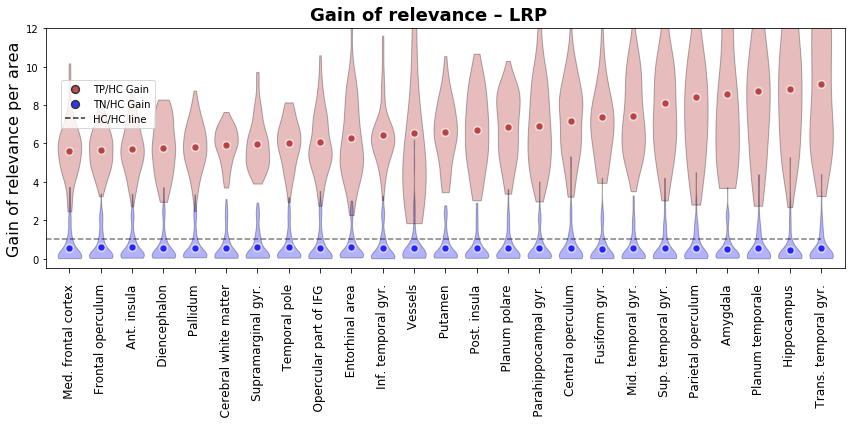

In [29]:
plt_opts = {
    "scatter_style": {
        "edgecolors": (.95, .95, .95), 
        "lw":1.5, 
        "s": 60, "alpha":.8},
   
    "color_ad": "firebrick",
    "color_hc": "green",
    "y_label": "Gain of relevance per area",
    "ad_label": "TP/HC Gain",
    "hc_label": "FN/HC Gain",
    "shift": 0,
    "ylim": (-0.5, 12)
    

}


fig, ax = plot_ad_hc(mean_gain_TP_LRP, None, plt_opts, sorting="gain",
                    idv_plots=None, shift=True,
                    the_labels=labels_gain_LRP)
ax.set_xlim(-1, 1+ len(labels_gain_LRP))
parts = ax.violinplot(gain_vals_TP_LRP, widths=.75, showextrema=False, points=100)
for pc in parts['bodies']:
    pc.set_facecolor('firebrick')
    pc.set_edgecolor('black')
    pc.set_alpha(.3)


    
    
plt_opts.update({
    "ad_label": "TN/HC Gain",
    "color_ad": "blue",
})
fig, ax = plot_ad_hc(mean_gain_TN_LRP, None, plt_opts, sorting="gain",
                    idv_plots=None, shift=True,
                    the_labels=labels_gain_LRP, fig=fig, ax=ax)
    

parts = ax.violinplot(gain_vals_TN_LRP, widths=.75, showextrema=False, points=100)
for pc in parts['bodies']:
    pc.set_facecolor('blue')
    pc.set_edgecolor('black')
    pc.set_alpha(.3)
ax.hlines(1, 0, len(labels_gain_LRP), linestyle="dashed", alpha =.5, label="HC/HC line")

leg = fig.legend(bbox_to_anchor=[.185, .85])

for lh in leg.legendHandles: 
    lh.set_alpha(.8)
    if "_edgecolors" in lh.__dict__:
        lh._edgecolors = [(.2, .2, .2)]

ax.set_xlim(0.25, len(labels_gain_LRP)+.75)

fig.tight_layout()
fig.suptitle("Gain of relevance – LRP", y=1.017, fontweight="bold", fontsize=18)
fig.savefig(os.path.join(data_path, "gain_LRP.pdf"), bbox_inches='tight')

#### Plot GB

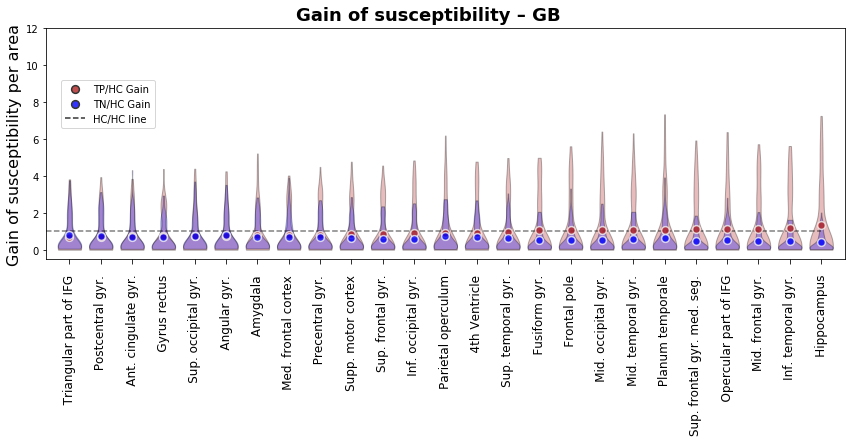

In [28]:
plt_opts = {
    "scatter_style": {
        "edgecolors": (.95, .95, .95), 
        "lw":1.5, 
        "s": 60, "alpha":.8},
    "color_ad": "firebrick",
    "color_hc": "green",
    "y_label": "Gain of susceptibility per area",
    "ad_label": "TP/HC Gain",
    "hc_label": "FN/HC Gain",
    "shift": 0,
    "ylim": (-0.5, 12)
    

}


fig, ax = plot_ad_hc(mean_gain_TP_GB, None, plt_opts, sorting="gain",
                    idv_plots=None, shift=True,
                    the_labels=labels_gain_GB)
ax.set_xlim(-1, 1+ len(labels_gain_GB))
parts = ax.violinplot(gain_vals_TP_GB, widths=.75, showextrema=False, points=100)
for pc in parts['bodies']:
    pc.set_facecolor('firebrick')
    pc.set_edgecolor('black')
    pc.set_alpha(.3)


    
    
plt_opts.update({
    "ad_label": "TN/HC Gain",
    "color_ad": "blue",
})
fig, ax = plot_ad_hc(mean_gain_TN_GB, None, plt_opts, sorting="gain",
                    idv_plots=None, shift=True,
                    the_labels=labels_gain_GB, fig=fig, ax=ax)
    

parts = ax.violinplot(gain_vals_TN_GB, widths=.75, showextrema=False, points=100)
for pc in parts['bodies']:
    pc.set_facecolor('blue')
    pc.set_edgecolor('black')
    pc.set_alpha(.3)
ax.hlines(1, 0, len(labels_gain_GB), linestyle="dashed", alpha =.5, label="HC/HC line")

leg = fig.legend(bbox_to_anchor=[.185, .85])

for lh in leg.legendHandles: 
    lh.set_alpha(.8)
    if "_edgecolors" in lh.__dict__:
        lh._edgecolors = [(.2, .2, .2)]

ax.set_xlim(0.25, len(labels_gain_GB)+.75)

fig.tight_layout()
fig.suptitle("Gain of susceptibility – GB", y=1.017, fontweight="bold", fontsize=18)
fig.savefig(os.path.join(data_path, "gain_GB.pdf"), bbox_inches='tight')

# Choosing individual patients

In [13]:
# Get all AD scores
ad_score_list = np.loadtxt(os.path.join(data_path, "ad_scores.txt"))
# Get indices of True positives
allowed_idcs = [i for i, _ in rs_per_area_LRP['TP']['Hippocampus']]
# Get indices of the TP indices that have a score higher than .9
# Store true indices and scores in one array
tmp = np.array([(idx, score) for idx, score in enumerate(ad_score_list) if idx in allowed_idcs and score>.9])
idcs = np.array(tmp[:, 0], dtype=int)
scores = tmp[:, 1]
M = np.zeros((len(idcs), len(idcs)))

In [14]:
idx_mapper = dict()
for n, idx in enumerate(idcs):
    _idx = np.argwhere(np.array(rs_per_area_LRP['TP']['CWM'])==idx)[0][0]
    # print(idx, _idx, rs_per_area_LRP['TP']['CWM'][_idx])
    # break
    idx_mapper.update({n: np.array([np.array(rs_per_area_LRP['TP'][l])[:, 1][_idx] for l in labels_norm_LRP])})

In [16]:
mini = np.inf
for i in range(len(M)):
    for j in range(len(M)):
        
        first = idx_mapper[i]
        second = idx_mapper[j]
        # Calculate cosine similarity
        M[i, j] = np.dot(first/np.linalg.norm(first),second/np.linalg.norm(second))
        if mini > M[i, j]:
            mini = M[i, j]
            max_pair = (i, j)
        

In [23]:
print("Most distant high AD patient indices:", idcs[list(max_pair)])

Most distant high AD patient indices: [  2 169]
